In [17]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
os.chdir("..")

In [2]:
from chess_analytics.game_library import GameLibrary
from chess_analytics.game_reader import GameReader

### Read in library of games

In [3]:
library = GameLibrary("data/user_games/Luc777")

Loading library (1969 files)...
...loaded.



In [4]:
library.df.tail(3)

,White,Black,Result,WElo,BElo,ECO,Opening,Date,Time,id,fname
1966,Luc777,annneverwins,0.0,1402,1381,C40,King's Knight Opening; C40 *,2011.08.22,300,https://www.chess.com/game/live/167183767,data/user_games/Luc777/2011/08/game_1.txt
1967,Luc777,MChamma8008,1.0,1151,991,C61,"Bird Defense, Ruy Lopez; C61 *",2011.11.07,900,https://www.chess.com/game/live/201921420,data/user_games/Luc777/2011/11/game_0.txt
1968,MChamma8008,Luc777,0.0,1088,1395,C20,King Pawn Game; C20 *,2011.11.07,300,https://www.chess.com/game/live/201920733,data/user_games/Luc777/2011/11/game_1.txt


### Winrates

In [5]:
library.winrates()

(0.4724245577523413, 0.4652777777777778)

In [7]:
def plot_wrs(white_wr, black_wr):
    """Plot 2 bars, mean to represent white/black winrate."""
    fig, ax = plt.subplots()
    ax.bar(['White'], [white_wr])
    ax.bar(['Black'], [black_wr], color='purple')

    ax.set_title("Win Rate by Color")
    ax.set_ylim(0,1.0)

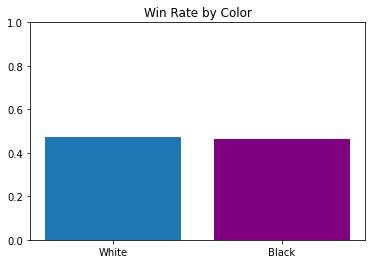

In [9]:
plot_wrs(*library.winrates())

In [11]:
def openings_and_games(library, color):
    """Returns a list of openings (specific) and the dataframe for one color."""
    openings = library.extract_openings_from_ecourl(color=color)
    return openings, library.df[library.df[color] == library.username]


In [12]:
### Winrate by opening, for black
openings, black_games = openings_and_games(library, 'Black')

In [13]:
openings

['Queens-Pawn-Opening',
 'Alekhines-Defense-Scandinavian-Variation-3.exd5',
 'Queens-Pawn-Opening-1...d5',
 'Four-Knights-Game-Spanish-Variation-Ranken-Variation-5...dxc6',
 'Alekhines-Defense-Scandinavian-Variation-3.exd5',
 'Scandinavian-Defense-Modern-Scandinavian-Gambit',
 'Indian-Game-Slav-Indian-Defense',
 'Queens-Pawn-Opening-Accelerated-London-System',
 'Queens-Gambit-Declined-Queens-Knight-Variation-3...Nf6',
 'Indian-Game-2.Nc3',
 'Vant-Kruijs-Opening-1...e5',
 'Queens-Pawn-Opening-Torre-Attack-3...e6',
 'Scandinavian-Defense-Modern-Variation-3.d4-c6-4.dxc6',
 'Alekhines-Defense-Scandinavian-Variation-3.exd5',
 'Trompowsky-Attack',
 'Kings-Indian-Attack-2...Nc6',
 'Birds-Opening-Dutch-Williams-Gambit',
 'Scandinavian-Defense',
 'Scandinavian-Defense',
 'Indian-Game',
 'Scandinavian-Defense-Modern-Marshall-Variation-4.c4-Nb6-5.Nc3',
 'Birds-Opening',
 'Alekhines-Defense-Scandinavian-Variation-3.exd5',
 'Scandinavian-Defense-Modern-Variation-3.c4',
 'Alekhines-Defense-Scandinav

In [23]:
def get_results_by_opening(df, openings, opening='Ruy-Lopez', color='White'):
    """Returns (wins, losses, draws) for a given opening/color."""
    mask = [opening in op for op in openings]
    df = df[mask]
    if color=="White":   
        return (len(df[df.Result==1]), len(df[df.Result==0]), len(df[df.Result==0.5]))
    else:
        return (len(df[df.Result==0]), len(df[df.Result==1]), len(df[df.Result==0.5]))

In [24]:
get_results_by_opening(black_games, openings, opening='Sicilian')

(0, 3, 0)

In [29]:
wins, losses, draws = get_results_by_opening(black_games, openings, opening='Kings-Pawn')
total = wins+losses+draws
print(total)
print(wins/total, losses/total, draws/total)

80
0.45 0.4875 0.0625


In [28]:
# White, playing Italian
get_results_by_opening(black_games, openings, opening='Italian-Game')

(22, 15, 1)

In [74]:
# Top openings (white)
openings_wh = library.opening_frequencies(color='White')

52
959


In [114]:
def results_by_openings(library, color = 'White'):
    openings, games = openings_and_games(library, color)
    # Top openings (white)
    opening_freqs = library.opening_frequencies(color=color)

    # Get results for top openings
    opening_wrs = {}
    for main_op in [x[0] for x in opening_freqs]:
        opening_wrs[main_op] = get_results_by_opening(games, openings, opening=main_op, color=color)
    
    return opening_wrs

In [124]:
results_by_opening_white = results_by_openings(library, 'White')

52
959


In [ ]:
import pandas as pd
# Using df_results_color (dataframe with Win, Loss, Draw by opening)
def plot_results_by_opening(library, color='White', num = 8):
    # Compute winrates by opening from library (~2K games/20s)
    results_by_opening = results_by_openings(library, color)
    df_results = pd.DataFrame(results_by_opening).T
    df_results.index = ["-".join(i.split("-")[:3]) for i in df_results.index]
    df_results.columns = ['Win', 'Loss', 'Draw']
    
    fig, ax = plt.subplots(figsize=(10,5))
    ax.set_title(f"Results by opening ({color})")
    ax = df_results.head(num).plot.barh(stacked=True, ax=ax, color=['g', 'crimson', 'grey'])
    for i,lbl in enumerate(ax.patches):
        j = i%num
        total = df_results.iloc[j]['Win'] + df_results.iloc[j]['Loss'] + df_results.iloc[j]['Draw']
        ax.annotate("{:.0f}%".format(lbl.get_width()*100/total), (lbl.get_x()+7, lbl.get_y()+.25),
                    fontsize=8.5, color='black')
    ax.invert_yaxis()
    ax.set_xlabel("Number of games played")


In [235]:
df_results.head(8)

In [271]:
plt.rcParams.update({'font.size': 9})


In [262]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [30]:
plot_results_by_opening(library, color='White')

NameError: name 'plot_results_by_opening' is not defined

In [248]:
# TODO - Ensure that if the first 3 tokens are correct, the opening is combined
df_results

,Win,Loss,Draw
Sicilian-Defense,76,90,7
Kings-Pawn-Opening,56,58,4
Scotch,57,61,4
Philidor-Defense,50,56,3
Scandinavian-Defense,33,31,2
Italian-Game,30,28,2
Ruy-Lopez-Opening,18,24,1
French-Defense-Normal,14,15,0
Pirc-Defense,12,14,3
Modern-Defense-with,14,13,1


73
1008


<IPython.core.display.Javascript object>


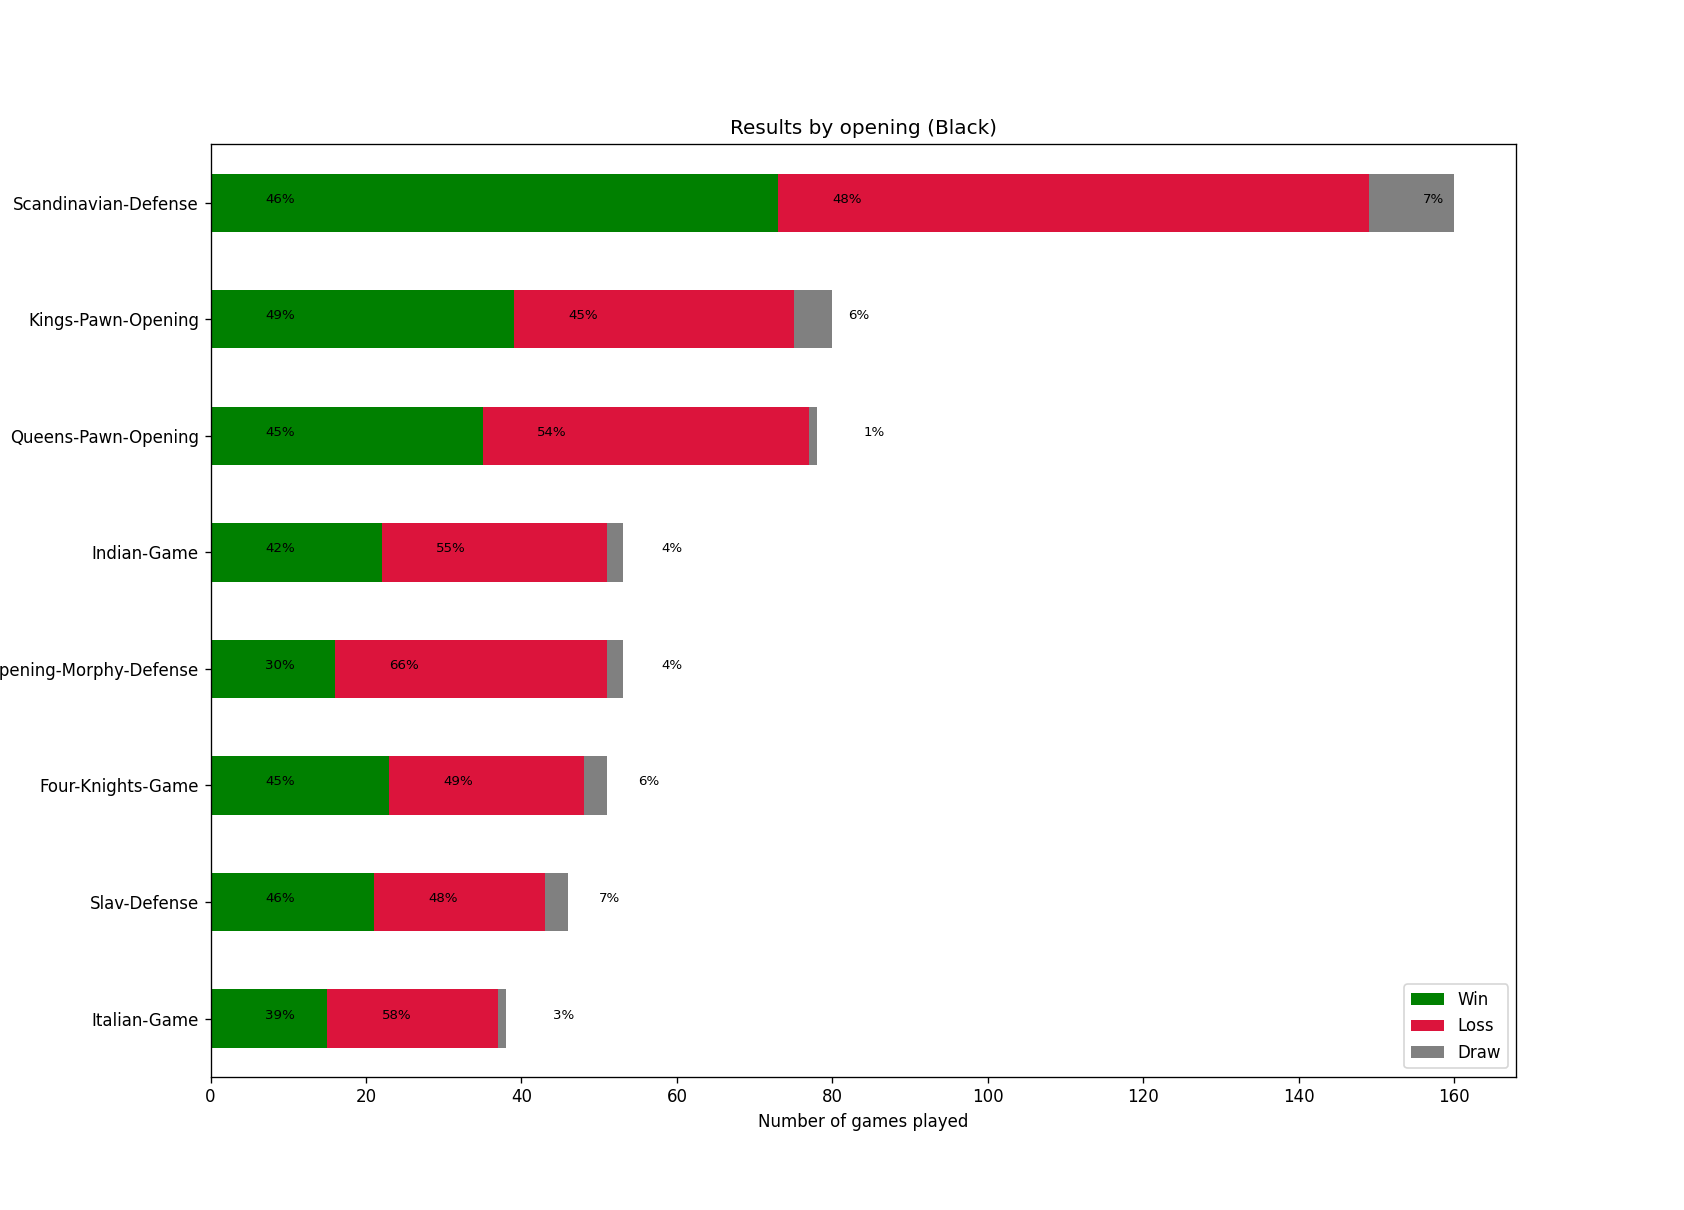

In [232]:
plot_results_by_opening(library, color='Black')

In [116]:
results_by_openings(library, 'Black')

73
1008


{'Scandinavian-Defense': (73, 76, 11),
 'Kings-Pawn-Opening': (39, 36, 5),
 'Queens-Pawn-Opening': (35, 42, 1),
 'Indian-Game': (22, 29, 2),
 'Ruy-Lopez-Opening-Morphy-Defense': (16, 35, 2),
 'Four-Knights-Game': (23, 25, 3),
 'Slav-Defense': (21, 22, 3),
 'Italian-Game': (15, 22, 1),
 'Alekhines-Defense-Scandinavian-Variation': (22, 13, 2),
 'Bishops-Opening': (17, 24, 1),
 'Vant-Kruijs-Opening': (14, 14, 0),
 'Petrovs-Defense': (16, 11, 0),
 'Kings-Indian-Defense': (14, 11, 1),
 'Kings-Gambit': (8, 16, 1),
 'Giuoco-Piano-Game': (9, 14, 0),
 'Reti-Opening': (14, 8, 1),
 'Scotch-Game': (6, 15, 0),
 'Vienna-Game': (10, 8, 2),
 'Queens-Gambit': (6, 12, 0),
 'Center-Game-Accepted': (10, 7, 0),
 'Ponziani-Opening': (5, 8, 1),
 'Kings-Fianchetto-Opening': (6, 5, 0),
 'Birds-Opening': (4, 5, 0),
 'English-Opening-Two-Knights-Variation': (5, 3, 0),
 'French-Defense': (3, 5, 0),
 'Van-Geet-Opening': (4, 3, 1),
 'Englund-Gambit-Declined-Reversed-French-Variation': (1, 5, 0),
 'Nimzowitsch-Larse

In [93]:
sum([x[1] for x in openings_wh])

959

In [94]:
#openings_wh

In [99]:
sum([sum(v) for v in opening_wrs.values()])

966

In [105]:
a = [x[1] for x in openings_wh]
b = [sum(x) for x in opening_wrs.values()]

In [110]:
# Slightly off, but only by 0.6%
[(i,j) for i,j in zip(a, b)]

[(171, 173),
 (118, 118),
 (118, 122),
 (109, 109),
 (66, 66),
 (60, 60),
 (43, 43),
 (29, 29),
 (29, 29),
 (28, 28),
 (25, 25),
 (18, 18),
 (17, 17),
 (16, 16),
 (14, 14),
 (11, 12),
 (11, 11),
 (7, 7),
 (6, 6),
 (6, 6),
 (5, 5),
 (4, 4),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1)]

In [106]:
b

[173,
 118,
 122,
 109,
 66,
 60,
 43,
 29,
 29,
 28,
 25,
 18,
 17,
 16,
 14,
 12,
 11,
 7,
 6,
 6,
 5,
 4,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [96]:
opening_wrs

{'Sicilian-Defense': (76, 90, 7),
 'Kings-Pawn-Opening': (56, 58, 4),
 'Scotch': (57, 61, 4),
 'Philidor-Defense': (50, 56, 3),
 'Scandinavian-Defense': (33, 31, 2),
 'Italian-Game': (30, 28, 2),
 'Ruy-Lopez-Opening': (18, 24, 1),
 'French-Defense-Normal-Variation': (14, 15, 0),
 'Pirc-Defense': (12, 14, 3),
 'Modern-Defense-with': (14, 13, 1),
 'Caro-Kann-Defense': (12, 12, 1),
 'French-Defense-Knight-Variation': (10, 8, 0),
 'Giuoco-Piano-Game': (8, 8, 1),
 'Petrovs-Defense-Classical-Variation': (8, 7, 1),
 'Alekhines-Defense': (7, 7, 0),
 'Four-Knights-Game': (8, 4, 0),
 'Nimzowitsch-Defense': (9, 2, 0),
 'French-Defense-Exchange-Variation': (6, 1, 0),
 'French-Defense-Marshall-Variation': (2, 2, 2),
 'Petrovs-Defense-Classical-Stafford-Gambit': (2, 4, 0),
 'Petrovs-Defense-Classical-Damiano-Variation': (4, 1, 0),
 'Reti-Opening-Tennison-Gambit': (1, 3, 0),
 'French-Defense-Queens-Knight-Variation': (2, 1, 0),
 'French-Defense-Rubinstein-Variation': (2, 1, 0),
 'French-Defense-Winaw

In [90]:
opening_wrs

{'Sicilian-Defense': (76, 90, 7),
 'Kings-Pawn-Opening': (56, 58, 4),
 'Scotch': (57, 61, 4),
 'Philidor-Defense': (50, 56, 3),
 'Scandinavian-Defense': (33, 31, 2),
 'Italian-Game': (30, 28, 2),
 'Ruy-Lopez-Opening': (18, 24, 1),
 'French-Defense-Normal-Variation': (14, 15, 0),
 'Pirc-Defense': (12, 14, 3),
 'Modern-Defense-with': (14, 13, 1),
 'Caro-Kann-Defense': (12, 12, 1),
 'French-Defense-Knight-Variation': (10, 8, 0),
 'Giuoco-Piano-Game': (8, 8, 1),
 'Petrovs-Defense-Classical-Variation': (8, 7, 1),
 'Alekhines-Defense': (7, 7, 0),
 'Four-Knights-Game': (8, 4, 0),
 'Nimzowitsch-Defense': (9, 2, 0),
 'French-Defense-Exchange-Variation': (6, 1, 0),
 'French-Defense-Marshall-Variation': (2, 2, 2),
 'Petrovs-Defense-Classical-Stafford-Gambit': (2, 4, 0),
 'Petrovs-Defense-Classical-Damiano-Variation': (4, 1, 0),
 'Reti-Opening-Tennison-Gambit': (1, 3, 0),
 'French-Defense-Queens-Knight-Variation': (2, 1, 0),
 'French-Defense-Rubinstein-Variation': (2, 1, 0),
 'French-Defense-Winaw

In [77]:
for o in openings:
    
    print(o)

Queens-Pawn-Opening
Alekhines-Defense-Scandinavian-Variation-3.exd5
Queens-Pawn-Opening-1...d5
Four-Knights-Game-Spanish-Variation-Ranken-Variation-5...dxc6
Alekhines-Defense-Scandinavian-Variation-3.exd5
Scandinavian-Defense-Modern-Scandinavian-Gambit
Indian-Game-Slav-Indian-Defense
Queens-Pawn-Opening-Accelerated-London-System
Queens-Gambit-Declined-Queens-Knight-Variation-3...Nf6
Indian-Game-2.Nc3
Vant-Kruijs-Opening-1...e5
Queens-Pawn-Opening-Torre-Attack-3...e6
Scandinavian-Defense-Modern-Variation-3.d4-c6-4.dxc6
Alekhines-Defense-Scandinavian-Variation-3.exd5
Trompowsky-Attack
Kings-Indian-Attack-2...Nc6
Birds-Opening-Dutch-Williams-Gambit
Scandinavian-Defense
Scandinavian-Defense
Indian-Game
Scandinavian-Defense-Modern-Marshall-Variation-4.c4-Nb6-5.Nc3
Birds-Opening
Alekhines-Defense-Scandinavian-Variation-3.exd5
Scandinavian-Defense-Modern-Variation-3.c4
Alekhines-Defense-Scandinavian-Variation-3.exd5
Indian-Game-Pawn-Push-Variation
Scandinavian-Defense-Modern-Variation
Scandin

In [76]:
openings

['Queens-Pawn-Opening',
 'Alekhines-Defense-Scandinavian-Variation-3.exd5',
 'Queens-Pawn-Opening-1...d5',
 'Four-Knights-Game-Spanish-Variation-Ranken-Variation-5...dxc6',
 'Alekhines-Defense-Scandinavian-Variation-3.exd5',
 'Scandinavian-Defense-Modern-Scandinavian-Gambit',
 'Indian-Game-Slav-Indian-Defense',
 'Queens-Pawn-Opening-Accelerated-London-System',
 'Queens-Gambit-Declined-Queens-Knight-Variation-3...Nf6',
 'Indian-Game-2.Nc3',
 'Vant-Kruijs-Opening-1...e5',
 'Queens-Pawn-Opening-Torre-Attack-3...e6',
 'Scandinavian-Defense-Modern-Variation-3.d4-c6-4.dxc6',
 'Alekhines-Defense-Scandinavian-Variation-3.exd5',
 'Trompowsky-Attack',
 'Kings-Indian-Attack-2...Nc6',
 'Birds-Opening-Dutch-Williams-Gambit',
 'Scandinavian-Defense',
 'Scandinavian-Defense',
 'Indian-Game',
 'Scandinavian-Defense-Modern-Marshall-Variation-4.c4-Nb6-5.Nc3',
 'Birds-Opening',
 'Alekhines-Defense-Scandinavian-Variation-3.exd5',
 'Scandinavian-Defense-Modern-Variation-3.c4',
 'Alekhines-Defense-Scandinav

In [75]:
openings_wh

[('Sicilian-Defense', 171),
 ('Kings-Pawn-Opening', 118),
 ('Scotch', 118),
 ('Philidor-Defense', 109),
 ('Scandinavian-Defense', 66),
 ('Italian-Game', 60),
 ('Ruy-Lopez-Opening', 43),
 ('French-Defense-Normal-Variation', 29),
 ('Pirc-Defense', 29),
 ('Modern-Defense-with', 28),
 ('Caro-Kann-Defense', 25),
 ('French-Defense-Knight-Variation', 18),
 ('Giuoco-Piano-Game', 17),
 ('Petrovs-Defense-Classical-Variation', 16),
 ('Alekhines-Defense', 14),
 ('Four-Knights-Game', 11),
 ('Nimzowitsch-Defense', 11),
 ('French-Defense-Exchange-Variation', 7),
 ('French-Defense-Marshall-Variation', 6),
 ('Petrovs-Defense-Classical-Stafford-Gambit', 6),
 ('Petrovs-Defense-Classical-Damiano-Variation', 5),
 ('Reti-Opening-Tennison-Gambit', 4),
 ('French-Defense-Queens-Knight-Variation', 3),
 ('French-Defense-Rubinstein-Variation', 3),
 ('French-Defense-Winawer-Delayed-Exchange-Variation', 3),
 ('Modern-Defense-Mongredien-Defense', 3),
 ('Petrovs-Defense-Classical-Cozio-Attack', 3),
 ('English-Opening

In [ ]:
# By opening:
white_games

In [ ]:
white_dr = len(white_games[results==1])/len(white_games)
white_wr

### Working with openings

In [5]:
%%time
openings = library.opening_frequencies()

72
1967
CPU times: user 24.2 s, sys: 99.6 ms, total: 24.3 s
Wall time: 24.3 s


In [6]:
openings_bk = library.opening_frequencies(color='Black')

73
1008


In [10]:
openings_bk[:10]

[('Scandinavian-Defense', 160),
 ('Kings-Pawn-Opening', 80),
 ('Queens-Pawn-Opening', 78),
 ('Indian-Game', 53),
 ('Ruy-Lopez-Opening-Morphy-Defense', 53),
 ('Four-Knights-Game', 48),
 ('Slav-Defense', 42),
 ('Italian-Game', 38),
 ('Alekhines-Defense-Scandinavian-Variation', 37),
 ('Bishops-Opening', 30)]

In [11]:
openings_wh = library.opening_frequencies(color='White')

52
959


In [12]:
openings_wh[:10]

[('Sicilian-Defense', 171),
 ('Kings-Pawn-Opening', 118),
 ('Scotch', 118),
 ('Philidor-Defense', 109),
 ('Scandinavian-Defense', 66),
 ('Italian-Game', 60),
 ('Ruy-Lopez-Opening', 43),
 ('French-Defense-Normal-Variation', 29),
 ('Pirc-Defense', 29),
 ('Modern-Defense-with', 28)]

In [7]:
library.username

'Luc777'

In [13]:
%matplotlib notebook
def plot_openings(opening_freqs):
    fig, ax = plt.subplots(figsize=(8,5))
    ax.barh([o[0] for o in opening_freqs],
           [o[1] for o in opening_freqs])
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    ax.invert_yaxis()


<IPython.core.display.Javascript object>


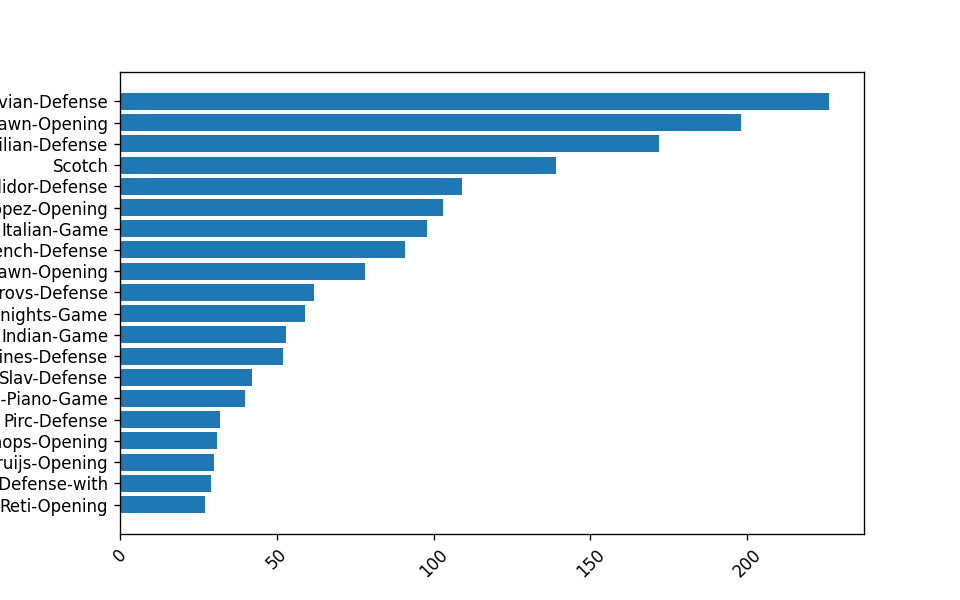

In [14]:
plot_openings(openings[:20])

In [34]:
ops[np.argmax(ops_counts)]

'https://www.chess.com/openings/Scandinavian-Defense-Mieses-Kotrc-Main-Line'

In [33]:
f = lambda i: ops_counts[i]
max(range(len(ops_counts)), key=f)

440

In [10]:
game.headers['ECOUrl'].split('/')[-1]

'Kings-Pawn-Opening-Kings-Knight-Variation'

In [18]:
dir(game)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'clean_pgn',
 'date',
 'describe',
 'df_eco',
 'df_nic',
 'eco_code',
 'eco_to_nic_opening',
 'eco_to_opening',
 'fgame',
 'game',
 'get_result',
 'headers',
 'infer_date',
 'load_eco_table',
 'load_nic_table',
 'moves',
 'opening',
 'parse_moves',
 'parse_pgn',
 'pgn',
 'print_game',
 'read_game',
 'result',
 'summarize',
 'time_control']

In [14]:
game.opening

"King's Knight Opening; C40 *"

In [8]:
library.df.iloc[1966]

White                                         Luc777
Black                                   annneverwins
Result                                             0
WElo                                            1402
BElo                                            1381
ECO                                              C40
Opening                 King's Knight Opening; C40 *
Date                                      2011.08.22
Time                                             300
id         https://www.chess.com/game/live/167183767
fname      data/user_games/Luc777/2011/08/game_1.txt
Name: 1966, dtype: object

### Random Game 

In [52]:
game_rnd.opening

'Classical Variation, Italian; C53 *'

In [53]:
str(game_rnd)

'1. e4 e5 2. Nf3 Nc6 3. d4 exd4 4. Bc4 Bc5 5. c3 Nf6 6. cxd4 Bb4+ 7. Bd2 Bxd2+ 8. Nbxd2 O-O 9. Qb3 Qe7 10. O-O Na5 11. Qc3 Nxc4 12. Qxc4 d6 13. Rac1 c6 14. d5 Bd7 15. Rfe1 Qd8 16. e5 cxd5 17. Qh4 dxe5 18. Rxe5 Re8 19. Rce1 Qc7 20. Rxe8+ Rxe8 21. Rxe8+ Bxe8 22. h3 Qc2 23. Kh2 Qxb2 24. Qa4 Bxa4 25. Ne5 Qxe5+ 26. g3 Nh5 27. Nf3 Qb2 28. h4 Nxg3 29. Kxg3 Qxa2 30. Kh3 Qb3'

In [54]:
game_rnd.moves

['e4',
 'e5',
 'Nf3',
 'Nc6',
 'd4',
 'exd4',
 'Bc4',
 'Bc5',
 'c3',
 'Nf6',
 'cxd4',
 'Bb4+',
 'Bd2',
 'Bxd2+',
 'Nbxd2',
 'O-O',
 'Qb3',
 'Qe7',
 'O-O',
 'Na5',
 'Qc3',
 'Nxc4',
 'Qxc4',
 'd6',
 'Rac1',
 'c6',
 'd5',
 'Bd7',
 'Rfe1',
 'Qd8',
 'e5',
 'cxd5',
 'Qh4',
 'dxe5',
 'Rxe5',
 'Re8',
 'Rce1',
 'Qc7',
 'Rxe8+',
 'Rxe8',
 'Rxe8+',
 'Bxe8',
 'h3',
 'Qc2',
 'Kh2',
 'Qxb2',
 'Qa4',
 'Bxa4',
 'Ne5',
 'Qxe5+',
 'g3',
 'Nh5',
 'Nf3',
 'Qb2',
 'h4',
 'Nxg3',
 'Kxg3',
 'Qxa2',
 'Kh3',
 'Qb3']

In [7]:
def play_nth_move(game, n):
    board = game.board()
    moves = list(game.mainline_moves())
    for move in moves[:n]:
        board.push(move)
    return board

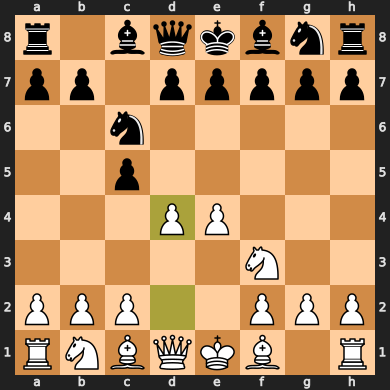

In [8]:
### Play first 5 ply
n = 5
play_nth_move(game_rnd.game, n)

In [9]:
game_rnd.describe()

['Luc777',
 'bendavidovich',
 1,
 '1378',
 '1378',
 'B32',
 'B32 *',
 '2021.01.26',
 '300',
 'https://www.chess.com/game/live/6349366503',
 'data/user_games/Luc777/2021/01/game_41.txt']

### Experimental: Game similarity
(Working with clean pgn and moves)

In [11]:
print(game_rnd.pgn)
print()
print(game_rnd.moves)

1. e4 c5 2. Nf3 Nc6 3. d4 cxd4 4. Nxd4 e5 5. Nf3 Nf6 6. Nc3 Bb4 7. Bc4 O-O 8. Qd3 a6 9. Bg5 h6 10. Bh4 Be7 11. O-O-O b5 12. Bxf6 Bxf6 13. Bd5 Bb7 14. h4 Ra7 15. g4 Nb4 16. Qe2 d6 17. h5 Nxd5 18. Nxd5 Bg5+ 19. Kb1 Qa5 20. Nh4 b4 21. Qc4 Bxd5 22. Rxd5 Qc7 23. Qxc7 Rxc7 24. Rxd6 Ra8 25. Rd5 Bf4 26. Ng2 a5 27. Nxf4 exf4 28. g5 hxg5 29. Rxg5 a4 30. h6 g6 31. Rb5 b3 32. cxb3 axb3 33. Rxb3 Rc4 34. h7+ Kh8 35. Rb7 Rxe4 36. Rxf7

['e4', 'c5', 'Nf3', 'Nc6', 'd4', 'cxd4', 'Nxd4', 'e5', 'Nf3', 'Nf6', 'Nc3', 'Bb4', 'Bc4', 'O-O', 'Qd3', 'a6', 'Bg5', 'h6', 'Bh4', 'Be7', 'O-O-O', 'b5', 'Bxf6', 'Bxf6', 'Bd5', 'Bb7', 'h4', 'Ra7', 'g4', 'Nb4', 'Qe2', 'd6', 'h5', 'Nxd5', 'Nxd5', 'Bg5+', 'Kb1', 'Qa5', 'Nh4', 'b4', 'Qc4', 'Bxd5', 'Rxd5', 'Qc7', 'Qxc7', 'Rxc7', 'Rxd6', 'Ra8', 'Rd5', 'Bf4', 'Ng2', 'a5', 'Nxf4', 'exf4', 'g5', 'hxg5', 'Rxg5', 'a4', 'h6', 'g6', 'Rb5', 'b3', 'cxb3', 'axb3', 'Rxb3', 'Rc4', 'h7+', 'Kh8', 'Rb7', 'Rxe4', 'Rxf7']


In [12]:
# Opera Game
opera_game = GameReader("data/opera_game.pgn")
opera_game.pgn

'1. e4 e5 2. Nf3 d6 3. d4 Bg4 4. dxe5 Bxf3 5. Qxf3 dxe5 6. Bc4 Nf6 7. Qb3 Qe7 8. Nc3 c6 9. Bg5 b5 10. Nxb5 cxb5 11. Bxb5+ Nbd7 12. O-O-O Rd8 13. Rxd7 Rxd7 14. Rd1 Qe6 15. Bxd7+ Nxd7 16. Qb8+ Nxb8 17. Rd8#'

### Comparing game similarity
- Using sets of moves, separated by color.
- Finding shared opening sequence in 2 games. 

In [13]:
def game_similarity(game_1_moves, game_2_moves):
    """Throw all moves into a bag, compare similarity (JS)"""
    overlapping_moves = set(game_1_moves).intersection(set(game_2_moves))
    return round(len(overlapping_moves)/len(set(game_1_moves)), 2)

In [14]:
# Similarity to opera_game
print(opera_game.moves)
print(game_rnd.moves)
print(game_similarity(opera_game.moves, game_rnd.moves))

['e4', 'e5', 'Nf3', 'd6', 'd4', 'Bg4', 'dxe5', 'Bxf3', 'Qxf3', 'dxe5', 'Bc4', 'Nf6', 'Qb3', 'Qe7', 'Nc3', 'c6', 'Bg5', 'b5', 'Nxb5', 'cxb5', 'Bxb5+', 'Nbd7', 'O-O-O', 'Rd8', 'Rxd7', 'Rxd7', 'Rd1', 'Qe6', 'Bxd7+', 'Nxd7', 'Qb8+', 'Nxb8', 'Rd8#']
['e4', 'c5', 'Nf3', 'Nc6', 'd4', 'cxd4', 'Nxd4', 'e5', 'Nf3', 'Nf6', 'Nc3', 'Bb4', 'Bc4', 'O-O', 'Qd3', 'a6', 'Bg5', 'h6', 'Bh4', 'Be7', 'O-O-O', 'b5', 'Bxf6', 'Bxf6', 'Bd5', 'Bb7', 'h4', 'Ra7', 'g4', 'Nb4', 'Qe2', 'd6', 'h5', 'Nxd5', 'Nxd5', 'Bg5+', 'Kb1', 'Qa5', 'Nh4', 'b4', 'Qc4', 'Bxd5', 'Rxd5', 'Qc7', 'Qxc7', 'Rxc7', 'Rxd6', 'Ra8', 'Rd5', 'Bf4', 'Ng2', 'a5', 'Nxf4', 'exf4', 'g5', 'hxg5', 'Rxg5', 'a4', 'h6', 'g6', 'Rb5', 'b3', 'cxb3', 'axb3', 'Rxb3', 'Rc4', 'h7+', 'Kh8', 'Rb7', 'Rxe4', 'Rxf7']
0.35


In [15]:
def game_similarity_colorful(game_1_moves, game_2_moves):
    """Get the overlap between white's moves and black's moves separately"""
    white_moves = game_1_moves[0::2]
    black_moves = game_1_moves[1::2]
    overlap_white = game_similarity(game_1_moves[0::2], game_2_moves[0::2])
    overlap_black = game_similarity(game_1_moves[1::2], game_2_moves[1::2])
    
    print(round(overlap_white,2))
    print(round(overlap_black,2))

In [16]:
game_similarity_colorful(opera_game.moves, game_rnd.moves)

0.41
0.25


In [17]:
def longest_common_sequence(game_1_moves, game_2_moves):
    """Get length of the longest_common_sequence between 2 games"""
    for i, (m1, m2) in enumerate(zip(game_1_moves, game_2_moves)):
        if m1 == m2:
            continue
        else:
            return game_1_moves[:i]
    return game_1_moves 

In [18]:
shared_opening = longest_common_sequence(opera_game.moves, game_rnd.moves)
print(shared_opening)
print(len(shared_opening))

['e4']
1
